# Оценка стоимости футболистов


Весенний проект по курсу «Наука о данных», Совместный бакалавриат ВШЭ-РЭШ, 2022–23  учебный год.

Автор работы: Власов Дмитрий.

Введение: 
Этот проект я хотел сделать еще много лет назад еще до того, как вообще познакомился с программированием. Примерно 10 лет назад я начал не только активно смотреть футбол, но и следить за трансферами, происходящими между клубами. Особенно меня привлекало анализировать стоимость и уже тогда я пытался понять из чего она складывается. Представляю вашему вниманию проект по оценке стоимости футболистов. Он состоит из двух частей. Основная часть посвящена самой стоимости, важным уточнениям и конечному выводу. Вторая часть – это небольшое финансовое дополнение к проекту в виде рассмотрения клубов как активов, потому что если игроки — это активы клуба, которые он пытается выгодно приобрести, то для простых людей сам клуб может рассматриваться как актив. 


In [150]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install geopandas
!pip install scikit-learn
!pip install Scrapy
!pip install networkx
!pip install seaborn
!pip install attrs

In [151]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [152]:
import requests
import pandas as pd
import numpy as np
import re
import csv
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
import networkx as nx
import seaborn as sns
import json

In [153]:
!scrapy runspider scraping.py

2023-06-11 21:00:29 [scrapy.utils.log] INFO: Scrapy 2.9.0 started (bot: scrapybot)
2023-06-11 21:00:29 [scrapy.utils.log] INFO: Versions: lxml 4.9.2.0, libxml2 2.9.14, cssselect 1.2.0, parsel 1.8.1, w3lib 2.1.1, Twisted 22.10.0, Python 3.8.8 (default, Apr 13 2021, 12:59:45) - [Clang 10.0.0 ], pyOpenSSL 23.2.0 (OpenSSL 3.1.1 30 May 2023), cryptography 41.0.1, Platform macOS-10.16-x86_64-i386-64bit
2023-06-11 21:00:29 [scrapy.crawler] INFO: Overridden settings:
{'SPIDER_LOADER_WARN_ONLY': True}
2023-06-11 21:00:29 [py.warnings] WARNING: /Users/dmitry/opt/anaconda3/lib/python3.8/site-packages/scrapy/utils/request.py:232: ScrapyDeprecationWarning: '2.6' is a deprecated value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting.

It is also the default value. In other words, it is normal to get this warning if you have not defined a value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting. This is so for backward compatibility reasons, but it will change in a future version of Scrapy.

Обычно большинство, как и меня в юном возрасте, интересует топ самых дорогих игроков. Здесь мы пользуемся самым известным сайтом, занимающимся оценкой стоимости футболистов. Забираем с сайта топ-25 самых дорогих футболистов. Также построим диаграмму, чтобы было красиво. При принятии решения на какую тему я буду писать проект, я подумал, будет интересным разобраться в механизме ценообразования. 

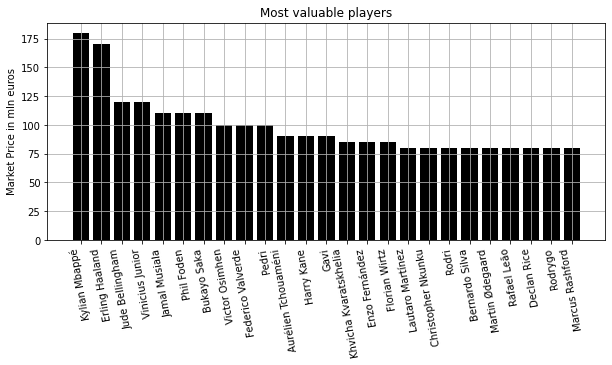

In [154]:
data = pd.read_csv('Football.csv')
data = data.sort_values(by='Price', ascending=False)
player_names = data['Name']
market_prices = data['Price']

plt.figure(figsize=(10, 4))
plt.bar(player_names, market_prices, color = 'black')
plt.ylabel('Market Price in mln euros')
plt.title('Most valuable players')
plt.xticks(rotation=100)
plt.grid(True)
plt.show()

Я заранее скачал статистические данные по всем футболистам из топ-5 лиг. Для разных позиций разные данные. Также я сделал таблицу с данными футболистов за прошлый год, которых купили в прошлом году. Это будет train для регрессий, прогнозирующих цену. Путем махинаций мы получаем в каждом примере сопоставление предсказаний цен на основе прошедших трансферов (чтобы оценить, насколько хорошо работает прогнозирование) и еще одного футболиста добавляем сами. Его цена – это и есть цель нашего проекта. 

In [155]:
GK_transfers_df = pd.read_csv('Transfers_GK.csv', sep = ';', index_col='Player')
GK_df = pd.read_csv('GK_2023.csv', sep = ';', index_col='Player')
Chosen_player = GK_df.loc[['Alisson']]
GK_transfers_df = pd.concat([GK_transfers_df, Chosen_player])

X = GK_transfers_df.drop(columns = ['Price'])
y = GK_transfers_df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=3, shuffle=False)
LR = linear_model.LinearRegression()
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
pd.DataFrame({'Prediction': y_pred, 'Transfer in 2022': y_test})

,Prediction,Transfer in 2022
Player,,
Fernando Pacheco,8.258544,2.2
Jasper Cillessen,7.324639,1.0
Alisson,15.474986,NaN


In [156]:
DF_transfers_df = pd.read_csv('Transfers_DF.csv', sep = ';', index_col='Player')
DF_df = pd.read_csv('DF_2023.csv', sep = ';', index_col='Player')
Chosen_player = DF_df.loc[['Danilo']]
DF_transfers_df = pd.concat([DF_transfers_df, Chosen_player])

X = DF_transfers_df.drop(columns = ['Price'])
y = DF_transfers_df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=3, shuffle=False)
LR = linear_model.LinearRegression()
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
pd.DataFrame({'Prediction': y_pred, 'Transfer in 2022': y_test})

,Prediction,Transfer in 2022
Player,,
Andrea Carboni,27.316855,4.0
Maxim Leitsch,17.482036,3.5
Danilo,25.229335,NaN


In [157]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

pd.DataFrame({'Prediction': y_pred, 'Transfer in 2022': y_test})

,Prediction,Transfer in 2022
Player,,
Andrea Carboni,19.099906,4.0
Maxim Leitsch,22.132998,3.5
Danilo,35.892339,NaN


In [158]:
FW_MF_transfers_df = pd.read_csv('Transfers_FW_MF.csv', sep = ';', index_col='Player')
FW_MF_df = pd.read_csv('FW_MF_2023.csv', sep = ';', index_col='Player')
Chosen_player = FW_MF_df.loc[['Lionel Messi']]
FW_MF_transfers_df = pd.concat([FW_MF_transfers_df, Chosen_player])

X = FW_MF_transfers_df.drop(columns = ['Price'])
y = FW_MF_transfers_df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=3, shuffle=False)
LR = linear_model.LinearRegression()
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
pd.DataFrame({'Prediction': y_pred, 'Transfer in 2022': y_test})

,Prediction,Transfer in 2022
Player,,
Mohamed Lamine Bayo,34.967533,14.0
Sekou Mara,33.925956,13.0
Lionel Messi,64.395305,NaN


In [159]:
neigh = KNeighborsRegressor(n_neighbors=5)

neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

pd.DataFrame({'Prediction': y_pred, 'Transfer in 2022': y_test})

,Prediction,Transfer in 2022
Player,,
Mohamed Lamine Bayo,35.66,14.0
Sekou Mara,19.54,13.0
Lionel Messi,22.00,NaN


В результате получаются расхождения и иногда довольно большие. Во-первых, стоит отметить, что мы работаем с недостаточно большой выборкой (так как в мире не происходит миллион трансферов каждый год). Во-вторых, стоимость может быть не объективной в силу, например, плохой оценки одной из сторон. В-третьих, для меньшего отклонения от трансферных цен, нужно искать лучшую из регрессий. Вероятно, это будет не линейная регрессия:) 
Также причиной может быть география игроков. Показываю карту, где родились футболисты из топ-5 лиг. Очевидно, что есть футбольные нации, из которых клубы активнее берут игроков просто потому статистически шансов больше и соответственно меньше рисков.  Футбольные аналитики даже говорят фразы на подобии «Был бы он испанец, стоил бы на 20 млн дороже». Однако это уже похоже на расизм и давайте пойдем дальше. 

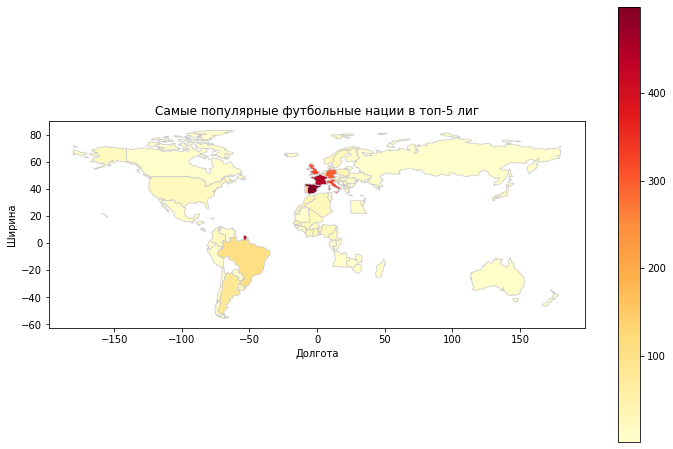

In [160]:
Geo_df = pd.read_csv('Geo.csv', sep = ";")

populations = dict(zip(Geo_df.iloc[:, 0], Geo_df.iloc[:, 1]))
E = populations["England"] 
W = populations["Wales"]
S = populations["Scotland"]
populations["United Kingdom"] = E + W + S
populations["United States of America"] = populations["United States"]

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world['density'] = world['name'].map(populations)

fig, ax = plt.subplots(figsize=(12, 8))
world.plot(column='density', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Самые популярные футбольные нации в топ-5 лиг')
ax.set_xlabel('Долгота')
ax.set_ylabel('Ширина')
plt.show()

Также на формировании цены влияет адаптируемость. В клубе, где игрок уже знает больше людей и с некоторыми из них у него уже есть сыгранность, футболист будет играть лучше с самого начала, а значит должен стоить дороже. Я демонстрирую граф хороших взаимоотношений футболистов, когда Месси, переходил в ПСЖ. Месси хорошо знал 8 игроков, которые также были знакомы между собой. Большинство уже играли в ПСЖ (с Месси в ПСЖ перешли Рамос и Хакими), поэтому граф почти полный. 

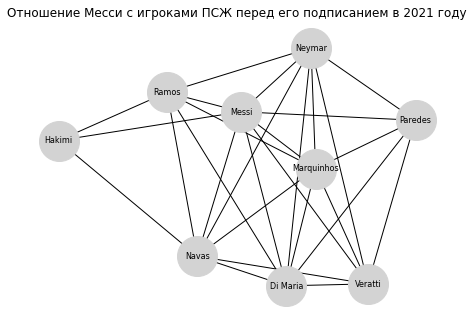

In [161]:
G = nx.Graph()

players = ['Messi', 'Navas', 'Marquinhos', 'Ramos', 'Hakimi', 'Paredes', 'Veratti', 'Neymar', 'Di Maria']
G.add_nodes_from(players)

connections = [('Messi', 'Navas'), ('Messi', 'Marquinhos'), ('Messi', 'Ramos'), ('Messi', 'Hakimi'), ('Messi', 'Paredes'), ('Messi', 'Veratti'), ('Messi', 'Neymar'), ('Messi', 'Di Maria'), ('Hakimi', 'Navas'), ('Hakimi', 'Ramos'), ('Navas', 'Marquinhos'), ('Navas', 'Ramos'), ('Navas', 'Veratti'), ('Navas', 'Neymar'), ('Navas', 'Di Maria'), ('Marquinhos', 'Ramos'), ('Marquinhos', 'Paredes'), ('Marquinhos', 'Veratti'), ('Marquinhos', 'Neymar'), ('Marquinhos', 'Di Maria'), ('Ramos', 'Neymar'), ('Ramos', 'Di Maria'), ('Paredes', 'Veratti'), ('Paredes', 'Neymar'), ('Paredes', 'Di Maria'), ('Veratti', 'Neymar'), ('Veratti', 'Di Maria'), ('Neymar', 'Di Maria')]
G.add_edges_from(connections)

pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_size=1600, node_color='lightgrey', edge_color='black', font_size=8, font_color='black')
plt.title('Отношение Месси с игроками ПСЖ перед его подписанием в 2021 году')
plt.show()

Последнее это длина контракта. Чем меньше лет осталось по контракту, тем дешевле будет футболист. Данные по контракту можно получить через данные на одном сайте по средствам API. Для того чтобы все работало нужен токен, я ввел свой, который выдается при регистрации. 

In [162]:
def get_data(api_url):
    headers = {
        'X-Auth-Token': '139f4ecf12064dde8cd1bc9eba299d7f'
    }
    response = requests.get(api_url, headers=headers)
    data = response.json()
    return data

def get_player_data(player_id):
    api_url = f'http://api.football-data.org/v4/persons/{player_id}'
    player_data = get_data(api_url)
    print(json.dumps(player_data, indent=4))
    print(json.dumps(player_data['currentTeam']['contract'], indent=4))

player_id = 22
get_player_data(player_id) 

{
    "id": 22,
    "name": "Fabi\u00e1n Ruiz",
    "firstName": "",
    "lastName": "Fabi\u00e1n Ruiz",
    "dateOfBirth": "1996-04-03",
    "nationality": "Spain",
    "section": "Midfield",
    "position": "Central Midfield",
    "shirtNumber": 8,
    "lastUpdated": "2023-05-01T19:34:12Z",
    "currentTeam": {
        "area": {
            "id": 2081,
            "name": "France",
            "code": "FRA",
            "flag": "https://crests.football-data.org/773.svg"
        },
        "id": 524,
        "name": "Paris Saint-Germain FC",
        "shortName": "PSG",
        "tla": "PSG",
        "crest": "https://crests.football-data.org/524.png",
        "address": "24, rue de Commandant Guibaud Paris 7501",
        "website": "http://www.psg.fr",
        "founded": 1904,
        "clubColors": "Red / Blue / White",
        "venue": "Parc des Princes",
        "runningCompetitions": [
            {
                "id": 2001,
                "name": "UEFA Champions League",
       

# Оценка клуба


Переходя ко второй части проекта, мне показалось интересным добавить, что как агенты оценивают футболистов, так и болельщики могут оценить, как идут дела у клуба и проинвестировать. Принцип похож на оценку любых других компаний только к просмотру финансовых отчетов добавляются чисто футбольные факторы. Скачав данные Forbes с 2007 года и данные индекса S&P 500 я построил график изменения цен клубов и индекса.

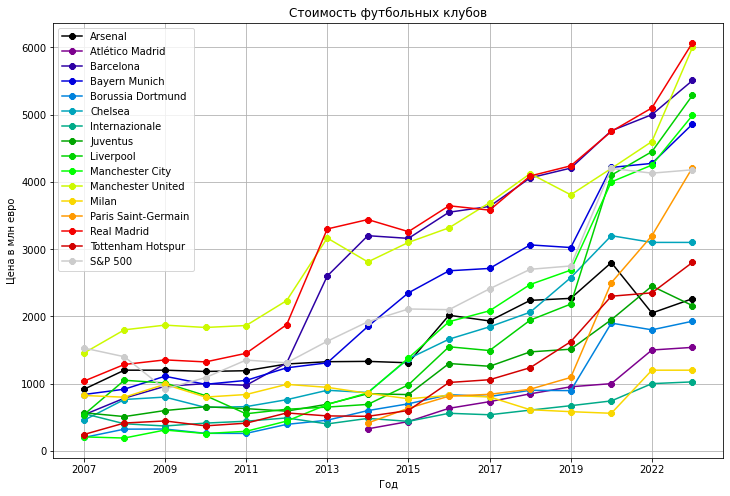

In [163]:
Clubs_value_df = pd.read_csv('Clubs_value.csv', sep = ";")

Clubs_value_df_transposed = Clubs_value_df.T
new_header = Clubs_value_df_transposed.iloc[0]
Clubs_value_df_transposed = Clubs_value_df_transposed[1:]
Clubs_value_df_transposed.columns = new_header

colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, len(Clubs_value_df_transposed)))
Clubs_value_df_transposed.plot(marker='8', figsize=(12, 8), color=colors)

plt.title('Стоимость футбольных клубов')
plt.xlabel('Год')
plt.ylabel('Цена в млн евро')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

Стоит отметить, что сейчас на бирже торгуется очень мало клубов. Из представленных в графике Манчестер Юнайтед, Ювентус, Арсенал и Боррусия Дортмунд. Но есть тренд к выходу на биржу (все больше клубов появляется на бирже), в то время как график показывает, что тот же ПСЖ в цене вырос в 9 раз за 9 лет. Вероятно, скоро будет весело не только на трансферном рынке, но и футбольной бирже, но это уже другая история. 